# Quantum transfer learning with Pennylane

Example based on the Quantum transfer learning pennylane tutorial but adapted for an NLP use case.

https://pennylane.ai/qml/demos/tutorial_quantum_transfer_learning

Idea: Instead of reducing the dimension of our BERT embeddings to the number of qubits of our model, we can use an AmplitudeEmbedding. Thus we need a minimum of log2(768)=9.58 < 10 qubits.

In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

# Pennylane
import pennylane as qml
from pennylane import numpy as np


# Plotting
import matplotlib.pyplot as plt

In [2]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    torch.mps.manual_seed(seed)

In [3]:
seed_everything(0)

## Setting of the main hyper-parameters of the model

In [4]:
n_qubits = 10                # Number of qubits
q_depth = 6                 # Depth of the quantum circuit (number of variational layers)
q_delta = 0.01              # Initial spread of random quantum weights

In [5]:
BATCH_SIZE = 2048
EPOCHS = 50
LR = 2e-1
GAMMA_LR = 0.5    # Learning rate reduction applied every STEP_LR epochs.
STEP_LR = 20
WEIGHT_DECAY = 0

In [6]:
dev = qml.device("default.qubit", wires=n_qubits)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Pennylane doesnt seem to support Mac Apple Silicon yet
#device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

print('Device used:', device)


Device used: cpu


## Dataset loading

As input we have a dataset of sentences, their corresponding sentiment (1 or 2) and their BERT embedding (768 dimensions)

In [8]:
df_dataset = pd.read_csv('../../../../data/amazonreview_reduced_bert_train_sentence.csv')
df_dataset.head(5)

,class,sentence,sentence_embedding
0,1,this one seemed inappropriate,[-7.07429171e-01 -9.20562893e-02 5.68922281e-...
1,1,Its Time Has Passed,[-0.93544328 -0.35473078 -0.44945127 0.866203...
2,1,This documentary is offensive,[-8.98015499e-01 -3.35524023e-01 5.96269146e-...
3,2,this one was ok,[-7.29380667e-01 -1.04420066e-01 7.20309854e-...
4,2,The lyrics are incredible,[-8.35999787e-01 -2.15908080e-01 1.77436873e-...


We can observe that the dataset is almost perfectly balanced (51.8% and 48.2%). Thus the accuracy should be a good metric to evaluate our model.

In [9]:
print(df_dataset["class"].value_counts())

2    1815
1    1685
Name: class, dtype: int64


In [10]:
def preprocess_dataset(csv_file):
    """
    Preprocess function for the dataset + Create train/test split
    """
    df_dataset = pd.read_csv(csv_file)

    df_dataset['sentence_embedding'] = np.array([np.fromstring(embedding.strip(' []'), sep=' ') for embedding in df_dataset['sentence_embedding']]).numpy().tolist()

    #Preprocess labels
    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(df_dataset['class'].values.reshape(-1, 1))
    df_dataset['class'] = enc.transform(df_dataset['class'].values.reshape(-1, 1)).toarray().tolist()

    X_train, X_test, y_train, y_test = train_test_split(df_dataset['sentence_embedding'], df_dataset['class'], test_size=0.2)

    return X_train, X_test, y_train, y_test



In [11]:
class BertEmbeddingDataset(Dataset):
    """Bert Embedding dataset."""

    def __init__(self, X, Y):
        self.X = X
        self.Y = Y


    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return torch.Tensor(self.X.iloc[idx]), torch.Tensor(self.Y.iloc[idx])

In [12]:
X_train, X_test, y_train, y_test = preprocess_dataset('../../../../data/amazonreview_reduced_bert_train_sentence.csv')

In [13]:
train_dataset = BertEmbeddingDataset(X_train, y_train)
training_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

validation_dataset = BertEmbeddingDataset(X_test, y_test)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

## Variational quantum circuit


In [14]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)


def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    # CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT
    for i in range(0, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

In [15]:
@qml.qnode(dev, interface="torch")
def quantum_net(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    #H_layer(n_qubits)

    # Embed features in the quantum node
    #RY_layer(q_input_features)
    qml.AmplitudeEmbedding(features=q_input_features, wires=range(n_qubits), normalize=True, pad_with=0.)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)

## Dressed quantum circuit

This is a concatenation of:

* A classical pre-processing layer (nn.Linear).
* A classical activation function (torch.tanh).
* A constant np.pi/2.0 scaling.
* The previously defined quantum circuit (quantum_net).
* A classical post-processing layer (nn.Linear).
* A classical activation function (torch.sigmoid).

In [16]:
class DressedQuantumNet(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self):
        """
        Definition of the *dressed* layout.
        """

        super().__init__()
        #self.pre_net = nn.Linear(768, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        # obtain the input features for the quantum circuit
        # by reducing the feature dimension from 512 to 4
        #pre_out = self.pre_net(input_features)
        #q_in = torch.tanh(pre_out) * np.pi / 2.0
        q_in = input_features

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = torch.hstack(quantum_net(elem, self.q_params)).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # return the two-dimensional prediction from the postprocessing layer
        return self.sigmoid(self.post_net(q_out))

In [17]:
model_hybrid = DressedQuantumNet()

# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)

In [18]:
print(model_hybrid.q_params.shape)

torch.Size([60])


## Training and results

Here we use a Binary Cross Entropy Loss, an Adam optimizer and a scheduler reducing the learning rate at an exponentially rate. 

In [19]:
criterion = nn.BCELoss()
optimizer_hybrid = optim.Adam(model_hybrid.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer_hybrid, step_size=STEP_LR, gamma=GAMMA_LR
)

#exp_lr_scheduler = lr_scheduler.CosineAnnealingLR(
#    optimizer_hybrid, T_max=EPOCHS, eta_min=1e-5)



We use tensorboard to log the hyperparameters, the loss and the accuracy of the model:

In [20]:
from torch.utils.tensorboard import SummaryWriter
import datetime

log_dir = "logs/fit_pennylane_with_amplitude_embeddings/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
summary_writer = SummaryWriter(log_dir=log_dir)

In [21]:
#Training loop
best_val_loss = 1000
best_val_acc = 0
best_train_loss = 1000
best_acc_train = 0

training_loss_list = []
validation_loss_list = []
training_acc_list = []
validation_acc_list = []
print("Training started:")

epoch_bar = tqdm(range(EPOCHS), total=EPOCHS, desc="Epochs", position=0, leave=True)

for epoch in epoch_bar:

    model_hybrid.train()

    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    it = 0
    training_bar = tqdm(training_dataloader, total=len(training_dataloader), desc="Training", position=0, leave=True)

    for inputs, labels in training_bar:
        batch_size_ = len(inputs)
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer_hybrid.zero_grad()

        # Track/compute gradient and make an optimization step only when training
        with torch.set_grad_enabled(True):
            outputs = model_hybrid(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            
            loss.backward()
            optimizer_hybrid.step()

        # Print iteration results
        running_loss += loss.item()*batch_size_

        batch_corrects = torch.sum(preds == torch.max(labels, 1)[1]).item()
        running_corrects += batch_corrects

        training_bar.set_postfix({"loss": f"{loss:.3f}", "acc": f"{batch_corrects/batch_size_:.3f}"})


    # Print epoch results
    train_loss = running_loss / len(training_dataloader.dataset)
    train_acc = running_corrects / len(training_dataloader.dataset)

    epoch_bar.set_postfix({"loss": f"{train_loss:.3f}", "acc": f"{train_acc:.3f}"})

    summary_writer.add_scalar("Training/Loss", train_loss, epoch)
    summary_writer.add_scalar("Training/Acurracy", train_acc, epoch)

    training_loss_list.append(train_loss)
    training_acc_list.append(train_acc)

    exp_lr_scheduler.step()

    if train_loss < best_train_loss:
        best_train_loss = train_loss

    if train_acc > best_acc_train:
        best_acc_train = train_acc

    
    ## VALIDATION PHASE
    validation_bar = tqdm(validation_dataloader, total=len(validation_dataloader), desc="Validation", position=0, leave=True)
    model_hybrid.eval()

    running_loss = 0.0
    running_corrects = 0


    for inputs, labels in validation_bar:
        batch_size_ = len(inputs)
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer_hybrid.zero_grad()

        # Track/compute gradient and make an optimization step only when training
        with torch.set_grad_enabled(False):
            outputs = model_hybrid(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        # Print iteration results
        running_loss += loss.item()*batch_size_
        batch_corrects = torch.sum(preds == torch.max(labels, 1)[1]).item()
        running_corrects += batch_corrects

        validation_bar.set_postfix({"loss": f"{loss:.3f}", "acc": f"{batch_corrects/batch_size_:.3f}"})
        it += 1

    validation_loss = running_loss / len(validation_dataloader.dataset)
    validation_acc = running_corrects / len(validation_dataloader.dataset)

    summary_writer.add_scalar("Validation/Loss", validation_loss, epoch)
    summary_writer.add_scalar("Validation/Acurracy", validation_acc, epoch)

    validation_loss_list.append(validation_loss)
    validation_acc_list.append(validation_acc)

    if validation_acc > best_val_acc:
        best_val_acc = validation_acc

    if validation_loss < best_val_loss:
        best_val_loss = validation_loss



Epochs: 100%|██████████| 50/50 [1:38:25<00:00, 118.10s/it, loss=0.620, acc=0.700]


In [22]:
summary_writer.add_hparams({'lr': LR, 'gamma_lr': GAMMA_LR, 'step_lr': STEP_LR, 'weight_decay': WEIGHT_DECAY},
                      {'hparam/loss_train': best_train_loss, 'hparam/acc_train': best_acc_train,
                       'hparam/loss_valid': best_val_loss, 'hparam/acc_valid': best_val_acc})

## Display loss and accuracy results

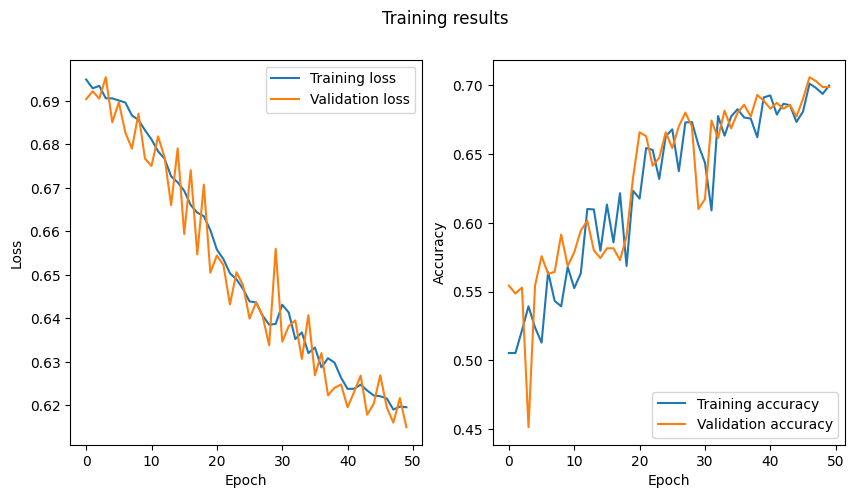

In [23]:
fig, ax1 = plt.subplots(1,2)

# Plot Training and Validation Loss
ax1[0].plot(training_loss_list, label='Training loss')
ax1[0].plot(validation_loss_list, label='Validation loss')
ax1[0].legend()
ax1[0].set_ylabel('Loss')
ax1[0].set_xlabel('Epoch')

# Plot Training and Validation Accuracy
ax1[1].plot(training_acc_list, label='Training accuracy')
ax1[1].plot(validation_acc_list, label='Validation accuracy')
ax1[1].legend()
ax1[1].set_ylabel('Accuracy')
ax1[1].set_xlabel('Epoch')


fig.suptitle('Training results')
fig.set_size_inches(10, 5)